# Recommendation systems using Olist dataset
> Olist e-commerce dataset to build simple recommender systems

- toc: true
- badges: true
- comments: true
- categories: [ecommerce]
- image: 

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from textblob import TextBlob

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d olistbr/brazilian-ecommerce

In [4]:
!unzip brazilian-ecommerce.zip

Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [13]:
products =  pd.read_csv('olist_products_dataset.csv', usecols=['product_id','product_category_name'])

orders = pd.read_csv('olist_orders_dataset.csv',usecols = ['order_id','customer_id'])

prod = pd.read_csv('olist_order_items_dataset.csv',usecols = ['product_id','order_id'])

customers = pd.read_csv('olist_customers_dataset.csv',usecols = ['customer_id','customer_zip_code_prefix','customer_city'])

location = pd.read_csv('olist_geolocation_dataset.csv', usecols = ['geolocation_zip_code_prefix'])

reviews = pd.read_csv('olist_order_reviews_dataset.csv',usecols = ['order_id','review_score','review_comment_message'])

In [20]:
def describe_data(df):
  print("Data Types:")
  print(df.dtypes)
  print("\n\nRows and Columns:")
  print(df.shape)
  print("\n\nColumn Names:")
  display(df.columns.tolist())
  print("\n\nNull values")
  print(df.isnull().sum())

In [21]:
describe_data(products)

Data Types:
product_id               object
product_category_name    object
dtype: object


Rows and Columns:
(32951, 2)


Column Names:


['product_id', 'product_category_name']



Null values
product_id                 0
product_category_name    610
dtype: int64


In [22]:
describe_data(customers)

Data Types:
customer_id                 object
customer_zip_code_prefix     int64
customer_city               object
dtype: object


Rows and Columns:
(99441, 3)


Column Names:


['customer_id', 'customer_zip_code_prefix', 'customer_city']



Null values
customer_id                 0
customer_zip_code_prefix    0
customer_city               0
dtype: int64


In [23]:
describe_data(reviews)

Data Types:
order_id                  object
review_score               int64
review_comment_message    object
dtype: object


Rows and Columns:
(100000, 3)


Column Names:


['order_id', 'review_score', 'review_comment_message']



Null values
order_id                      0
review_score                  0
review_comment_message    58247
dtype: int64


In [24]:
describe_data(orders)

Data Types:
order_id       object
customer_id    object
dtype: object


Rows and Columns:
(99441, 2)


Column Names:


['order_id', 'customer_id']



Null values
order_id       0
customer_id    0
dtype: int64


In [25]:
describe_data(location)

Data Types:
geolocation_zip_code_prefix    int64
dtype: object


Rows and Columns:
(1000163, 1)


Column Names:


['geolocation_zip_code_prefix']



Null values
geolocation_zip_code_prefix    0
dtype: int64


In [26]:
describe_data(prod)

Data Types:
order_id      object
product_id    object
dtype: object


Rows and Columns:
(112650, 2)


Column Names:


['order_id', 'product_id']



Null values
order_id      0
product_id    0
dtype: int64


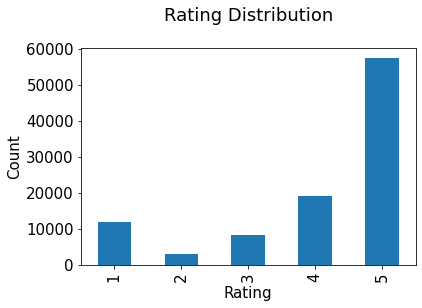

In [27]:
plt.rc("font", size=15)
reviews.review_score.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

### Popularity based recommender

In [28]:
comb_product = pd.merge(products, prod, on ='product_id')

In [29]:
comb_product_review = pd.merge(comb_product,reviews, on = 'order_id')
comb_product_review.head(5)

,product_id,product_category_name,order_id,review_score,review_comment_message
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,e17e4f88e31525f7deef66779844ddce,5,Super adooorei o delineador ele é bem preto e ...
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,5236307716393b7114b53ee991f36956,5,Excelente apontador! Em 3 segundos uma ponta p...
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,01f66e58769f84129811d43eefd187fb,5,NaN
3,cef67bcfe19066a932b7673e239eb23d,bebes,143d00a4f2dde4e0364ee1821577adb3,1,modelo comprado: travesseiro memoria carinho B...
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,86cafb8794cb99a9b1b77fc8e48fbbbb,5,NaN


In [30]:
review_count = pd.DataFrame(comb_product_review.groupby('product_category_name')['review_score'].count())
review_count.sort_values('review_score', ascending=False).head()

,review_score
product_category_name,
cama_mesa_banho,11272
beleza_saude,9728
esporte_lazer,8701
moveis_decoracao,8416
informatica_acessorios,7895


#### Conclusion : These are the top 5 products with highest review score and so we can recommend these ones. Best recommended technique when completely new user visits an e-commerce site, that site will not have any past history


### KNN collaborative method

The collaborative filtering algorithm uses “User Behavior” for recommending items.

kNN is a machine learning algorithm to find clusters of similar users based on ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item and one column for each user location


In [33]:
comb_product_review = comb_product_review[comb_product_review.review_score >= 3]

In [34]:
prod_order_review = pd.merge(comb_product_review, orders , on = 'order_id')

In [40]:
customers.head()

,customer_id,customer_zip_code_prefix,customer_city
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca
1,18955e83d337fd6b2def6b18a428ac77,9790,sao bernardo do campo
2,4e7b3e00288586ebd08712fdd0374a03,1151,sao paulo
3,b2b6027bc5c5109e529d4dc6358b12c3,8775,mogi das cruzes
4,4f2d8ab171c80ec8364f7c12e35b23ad,13056,campinas


In [43]:
cust_location = pd.merge(customers, location, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')

In [44]:
cust_location.head(5)

,customer_id,customer_zip_code_prefix,customer_city,geolocation_zip_code_prefix
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,14409
1,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,14409
2,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,14409
3,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,14409
4,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,14409


In [45]:
cust_prod_location = pd.merge (prod_order_review, cust_location, on = 'customer_id' )

In [46]:
print(cust_prod_location['review_score'].quantile(np.arange(.9,1,.01)))

0.90    5.0
0.91    5.0
0.92    5.0
0.93    5.0
0.94    5.0
0.95    5.0
0.96    5.0
0.97    5.0
0.98    5.0
0.99    5.0
Name: review_score, dtype: float64


In [47]:
from scipy.sparse import csr_matrix

location_user_rating = cust_prod_location.drop_duplicates(['customer_zip_code_prefix', 'product_category_name'])

location_user_rating_pivot = location_user_rating.pivot(index = 'product_category_name', columns = 'customer_zip_code_prefix', values = 'review_score').fillna(0)

location_user_rating_matrix = csr_matrix(location_user_rating_pivot.values)

In [54]:
location_user_rating_pivot.sample(10).iloc[:,:10]

customer_zip_code_prefix,1003,1004,1005,1006,1007,1008,1009,1011,1012,1013
product_category_name,,,,,,,,,,
construcao_ferramentas_iluminacao,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
perfumaria,0.0,4.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0
ferramentas_jardim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fashion_bolsas_e_acessorios,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pet_shop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eletrodomesticos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
moveis_cozinha_area_de_servico_jantar_e_jardim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
livros_tecnicos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
malas_acessorios,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

model_knn.fit(location_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [49]:
query_index = np.random.choice(location_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(location_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

12


In [50]:
location_user_rating_pivot.index[query_index]

'beleza_saude'

In [51]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(location_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, location_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for beleza_saude:

1: cama_mesa_banho, with distance of 0.5518436931335353:
2: esporte_lazer, with distance of 0.5619968142285134:
3: utilidades_domesticas, with distance of 0.584788746517453:
4: informatica_acessorios, with distance of 0.58869735760611:
5: moveis_decoracao, with distance of 0.5935567058997615:


### Recommendation based on sentiment analysis of Review message

In [55]:
prod_order_review

,product_id,product_category_name,order_id,review_score,review_comment_message,customer_id
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,e17e4f88e31525f7deef66779844ddce,5,Super adooorei o delineador ele é bem preto e ...,f8a3e963a310aa58b60a5b1fed5bceb5
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,5236307716393b7114b53ee991f36956,5,Excelente apontador! Em 3 segundos uma ponta p...,03fc97548af8f58fefc768d12b546c9c
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,01f66e58769f84129811d43eefd187fb,5,NaN,e41819d1c95c12c9ce495b630eab8aee
3,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,86cafb8794cb99a9b1b77fc8e48fbbbb,5,NaN,c11c31965ff02cc1d7132df8edfcbc22
4,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,c214058828b43a44f352b56ff2d5c0a5,5,NaN,3f3a10ec410c8efb0ca799fa7705d07e
...,...,...,...,...,...,...
94546,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,59e88b7d3675e89aceaf86f372d3bc9a,4,Bom,e750210dde7e68dbd5194c0809e97f7e
94547,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,6e4465d771f02e4fe335225de3c6c043,5,NaN,0f139d1b208a62a37671423e5eff5016
94548,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,6e4465d771f02e4fe335225de3c6c043,5,NaN,0f139d1b208a62a37671423e5eff5016
94549,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,6e4465d771f02e4fe335225de3c6c043,5,NaN,0f139d1b208a62a37671423e5eff5016


In [56]:
prod_order_review.dropna(subset = ["review_comment_message"], inplace=True)

In [57]:
final = prod_order_review[['product_category_name','review_comment_message']]

In [58]:
pd.set_option('mode.chained_assignment', None)

# Convert to list
final['data'] = final['review_comment_message'].to_list()

In [59]:
# Pre-processing steps for data

final['data'] = [re.sub('\s*@\s*\s?', ' ', str(sent)) for sent in final['data']]

final['data'] = [re.sub('\?', ' ', str(sent)) for sent in final['data']]

final['data'] = [re.sub('\_', ' ', str(sent)) for sent in final['data']]

final['data'] = [re.sub('@"[\d-]"', ' ', str(sent)) for sent in final['data']]

# Remove new line characters
final['data'] = [re.sub('\s+', ' ', str(sent)) for sent in final['data']]

# Remove distracting single quotes
final['data'] = [re.sub("\'", " ", str(sent)) for sent in final['data']]

#Converting into lowercase
final['data']=final['data'].str.lower()


In [ ]:
bloblist_desc = list()

df_comments= final['data'].astype(str)

for row in df_comments:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_comments_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['review_comment_message','sentiment','polarity'])
 
def f(df_comments_polarity_desc):
    if df_comments_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif df_comments_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

df_comments_polarity_desc['Sentiment_Type'] = df_comments_polarity_desc.apply(f, axis=1)

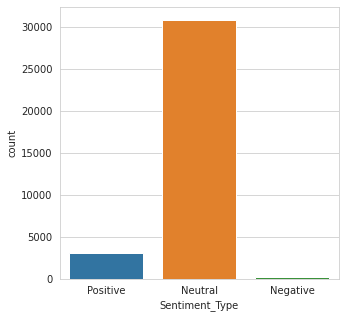

In [61]:
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data = df_comments_polarity_desc)

In [62]:
df_comments_polarity_desc

,review_comment_message,sentiment,polarity,Sentiment_Type
0,super adooorei o delineador ele é bem preto e ...,0.333333,0.666667,Positive
1,excelente apontador! em 3 segundos uma ponta p...,0.000000,0.000000,Neutral
2,muito bom,0.000000,0.000000,Neutral
3,produto tem um tom de cor diferente da foto. h...,0.000000,0.000000,Neutral
4,o produto que chegou é mais bonito do que eu e...,0.000000,0.000000,Neutral
...,...,...,...,...
34056,"produto de ótima qualidade, fiquei super feliz...",0.333333,0.666667,Positive
34057,muito boa a loja esta de parabéns,0.000000,0.000000,Neutral
34058,bom,0.000000,0.000000,Neutral
34059,bom,0.000000,0.000000,Neutral


In [63]:
review_analytics = pd.merge(final, df_comments_polarity_desc, on = 'review_comment_message')

In [64]:
review_analytics = review_analytics[review_analytics.Sentiment_Type == 'Positive']

In [65]:
review_analytics.product_category_name.unique()

array(['cool_stuff', 'beleza_saude', 'artigos_de_festas',
       'informatica_acessorios', 'moveis_decoracao', 'perfumaria',
       'telefonia', 'esporte_lazer', 'utilidades_domesticas', 'papelaria',
       'pet_shop', 'cama_mesa_banho', 'relogios_presentes',
       'telefonia_fixa', 'pcs', 'automotivo', 'alimentos', 'eletronicos',
       'ferramentas_jardim', nan, 'brinquedos',
       'construcao_ferramentas_construcao', 'eletrodomesticos',
       'fashion_bolsas_e_acessorios', 'livros_interesse_geral',
       'malas_acessorios', 'portateis_casa_forno_e_cafe', 'climatizacao',
       'consoles_games', 'bebes', 'audio', 'instrumentos_musicais',
       'artigos_de_natal', 'eletroportateis', 'moveis_sala',
       'construcao_ferramentas_ferramentas', 'moveis_escritorio',
       'fraldas_higiene', 'industria_comercio_e_negocios',
       'alimentos_bebidas'], dtype=object)

In [66]:
len(review_analytics.product_category_name.unique())

40

####  Conclusion - These are the products recommended based on sentiments 

### Future Ideas:

1. Recommendation system using Hybrid approach

2. System can be particularly built using data of customers, products at different location 

3. Can also try system with customer payment history
    